This notebook can be used to analyse a mixture model


In [1]:
# Some setup code for imports
import os
import sys
import math
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [2]:

# First we will load the validation set with the calculated scores.
dataset_loader = BayesRiskDatasetLoader("validation_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
validation_dataset = dataset_loader.load(type="pandas")


In [3]:
import numpy as np
def calculate_mbr_scores(entry):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util * entry["utilities_count"])/count
        scores.append(score)
    return scores

In [4]:
### Next up we will read the trained model and calculate the score given by the heads
from models.pl_predictive.PLPredictiveModelFactory import PLPredictiveModelFactory

model_name = "gaussian"
duplicate_hypotheses = False
path = '../../results/{}/'.format(model_name)
model_path = "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/"+ model_name + '/'
model_samples_path = "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/"+ model_name + '/samples.parquet'
model, factory = PLPredictiveModelFactory.load(model_path)
model = model.eval()

C:\Users\gerso\FBR\NMT/tatoeba-de-en/model
1.001726887106992e-06
gaussian-full


In [5]:
from models.MBR_model.GaussianMixtureMBRModel import GaussianMixtureMBRModel
from models.MBR_model.StudentTMixtureMBRModel import StudentTMixtureMBRModel
from models.MBR_model.GaussianMBRModel import GaussianMBRModel
from models.pl_predictive.StudentTMixturePredictiveModel import StudentTMixturePredictiveModel
from models.pl_predictive.GaussianMixturePredictiveModel import GaussianMixturePredictiveModel
from models.pl_predictive.GaussianPredictiveModel import GaussianPredictiveModel

if type(model) == StudentTMixturePredictiveModel:
    wrapped_model = StudentTMixtureMBRModel(model)
elif type(model) == GaussianMixturePredictiveModel:
    wrapped_model = GaussianMixtureMBRModel(model)
elif type(model) == GaussianPredictiveModel:
    wrapped_model = GaussianMBRModel(model)
else:
    raise ValueError("model not found")




In [6]:
import seaborn as sns


def get_repeated_utils(utilities, count):
    
    repeated_utils = []
    for util in utilities:
        
        r = []
        for u, c in zip(util, count):
            r += [u] * c
        repeated_utils.append(r)
    return repeated_utils

In [7]:
import matplotlib.pyplot as plt
def clean(s):
    return s.replace('?', '')

In [21]:
# We are going to create a new dataframe in which add the samples of the model. We do this such that we can analyse multiple models if needed
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

all_samples = []

for i, row in tqdm(validation_dataset.data.iterrows(), total=2500):
   
    hypotheses = row["hypotheses"].tolist()
    source = str(row["source"])
    samples = wrapped_model.get_samples([source] * len(hypotheses), hypotheses)
    samples = samples.permute([1, 0, 2]).squeeze(-1).cpu().numpy().tolist()
    all_samples.append(samples)
    

<class 'models.MBR_model.GaussianMBRModel.GaussianMBRModel'>


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:41<00:00, 15.48it/s]


NameError: name 'result' is not defined

In [22]:

df = pd.DataFrame.from_dict({"samples": all_samples}).to_parquet(model_samples_path)


In [10]:


def plot_distributions(source, target, hypotheses, utilities, model, model_name, max_show=5, path='./validtion_imgs/', ):
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    
    sns.set_style("dark")
    
    
    samples = model.get_samples([source]*len(hypotheses), hypotheses, n_samples=1000)
    
    samples = samples.permute([1, 0, 2]).squeeze(-1).cpu().numpy().tolist()
 
    
    
#     monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
#     predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
#     hypotheses_sorted = hypotheses[sorted_indices][:max_show]
    
    utilities = utilities[:max_show]
    samples = samples[:max_show]
    hypotheses = hypotheses[:max_show]
    data = {
        "Utility": [],
        "Hypothesis": [],
        "Samples": [] # Either Monte-carlo or predictive
        
    }
    
    
    
    
    for u, h in zip(utilities, hypotheses):
        
        data["Utility"] += u
        data["Hypothesis"] += [h] * len(u)
        data["Samples"] += ["Data"] * len(u)
    for s, h in zip(samples, hypotheses):
        data["Utility"] += s
        data["Hypothesis"] += [h] * len(s)
        data["Samples"] += ["Model"] * len(s)
    df = pd.DataFrame.from_dict(data)
    g = sns.displot(df, x='Utility', col="Hypothesis", row='Samples', facet_kws=dict(margin_titles=True))
    title = '{} \nSource: {} \ntarget: {}'.format(model_name, source, target)
    
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(title)

    def specs(x, **kwargs):
        plt.axvline(x.mean(), c="red", alpha=0.5, linestyle='--')
        

    g.map(specs, 'Utility')
    fig = g.fig
    
    name = "/{}.png".format(cleaned_source)
    save_file = str(path) + name 
    fig.savefig(save_file) 
    
    
    
#     sns.distplot()


C:\Users\gerso\anaconda3\envs\thesis\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\gerso\AppData\Local\Temp/ipykernel_3180/1885958046.py:56: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.savefig(save_file)


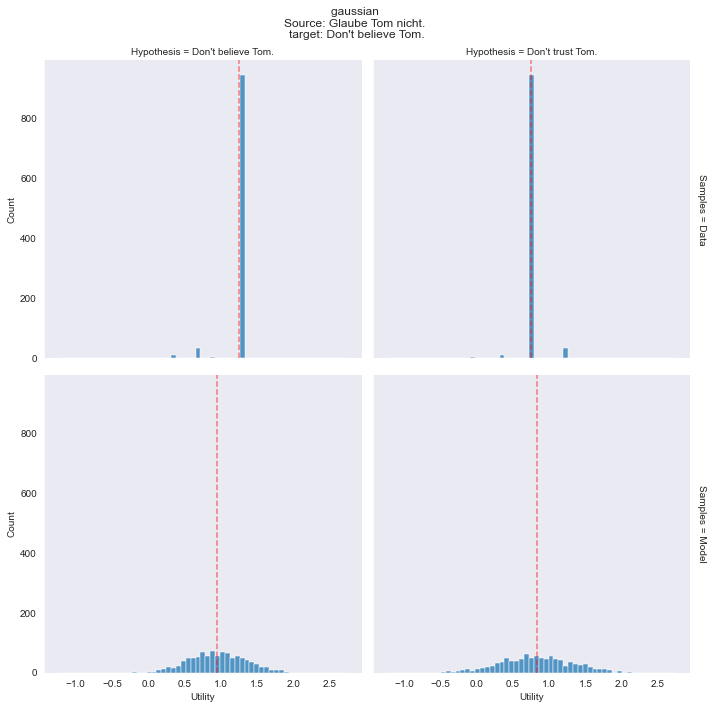

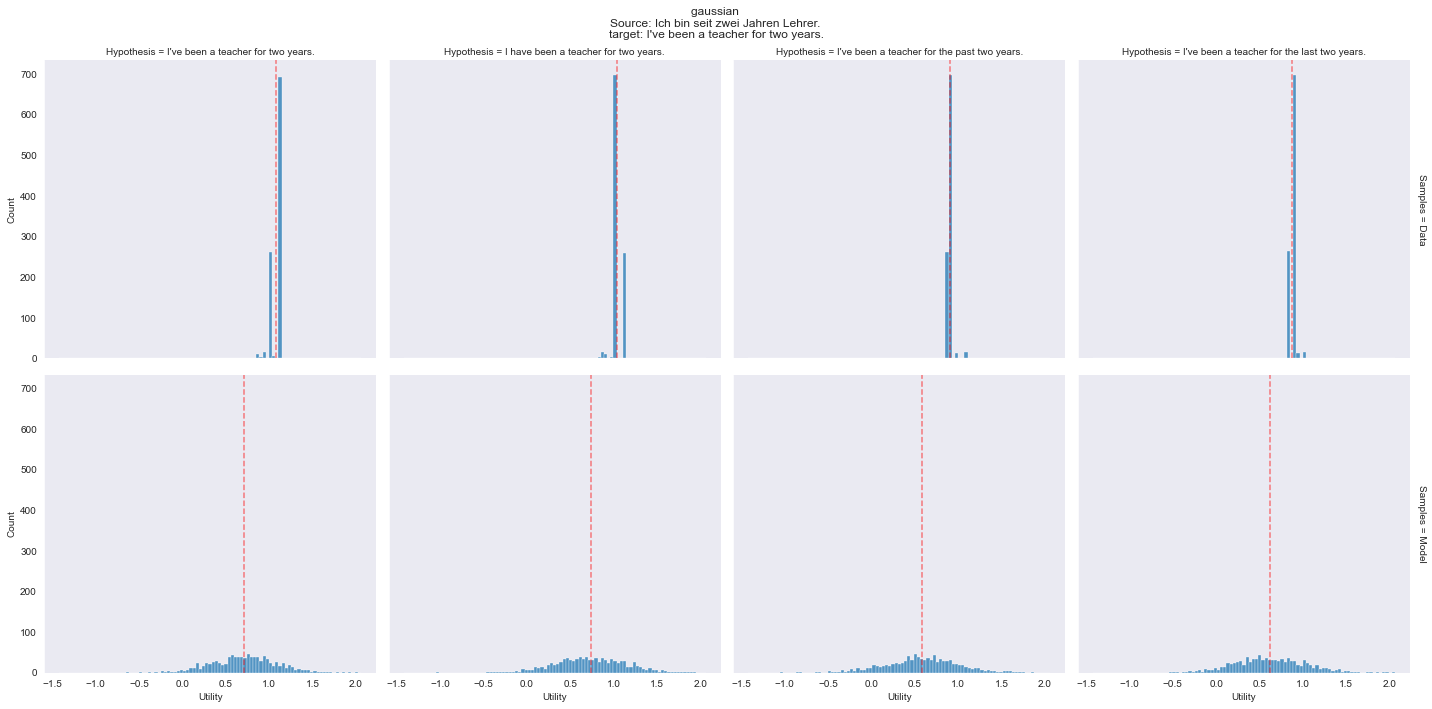

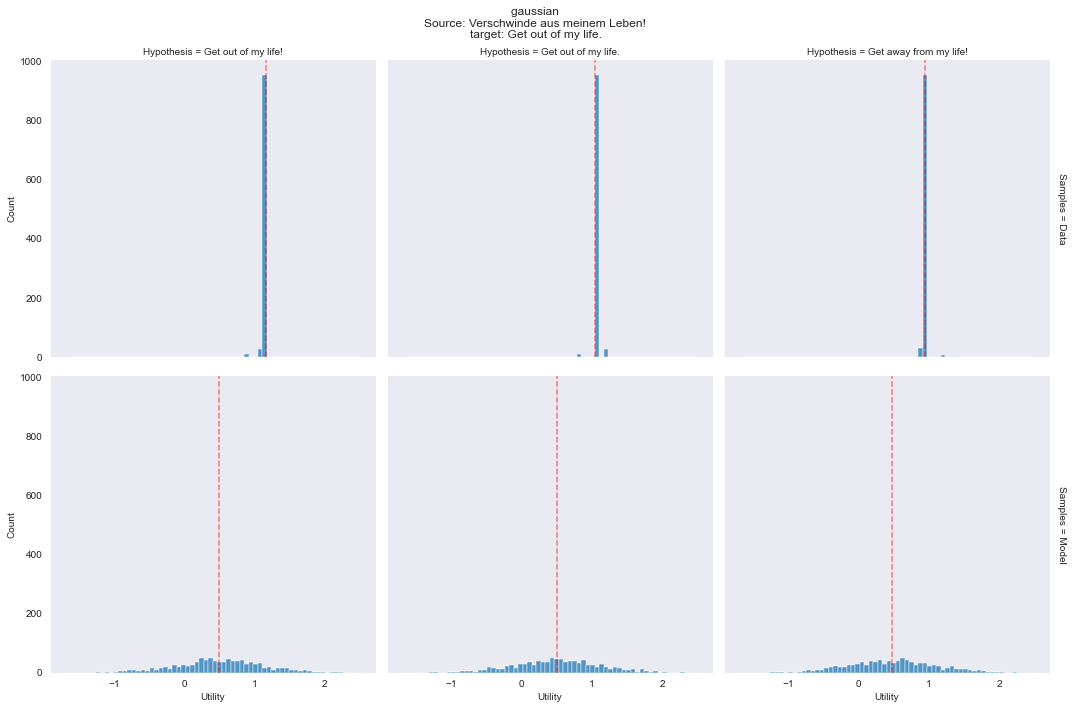

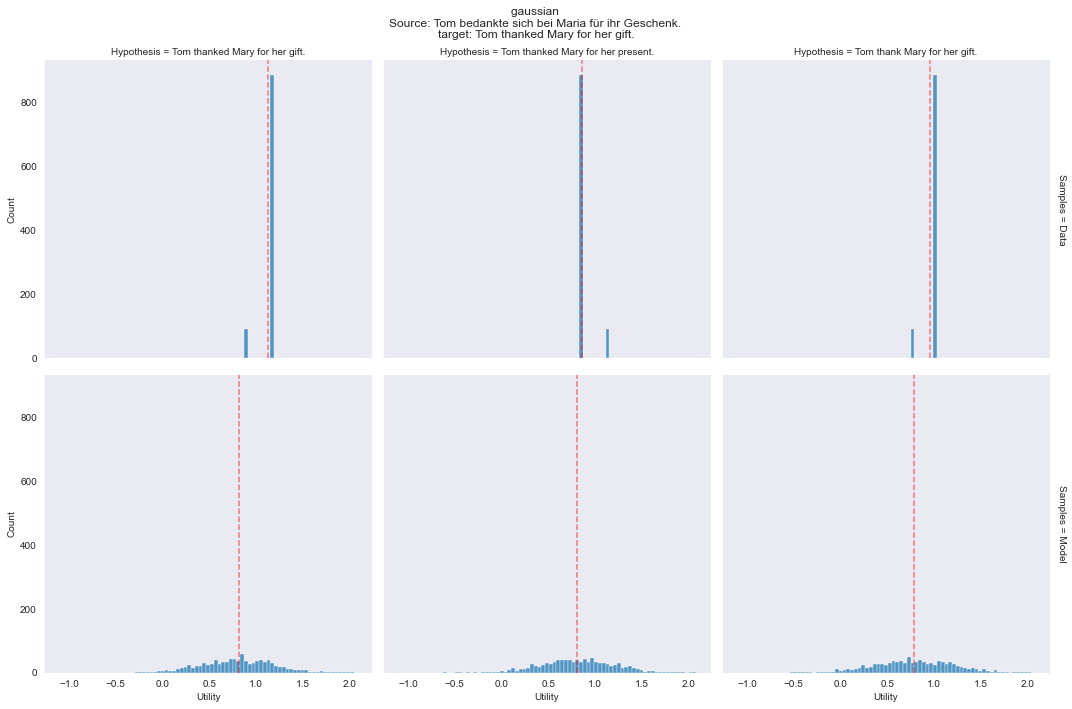

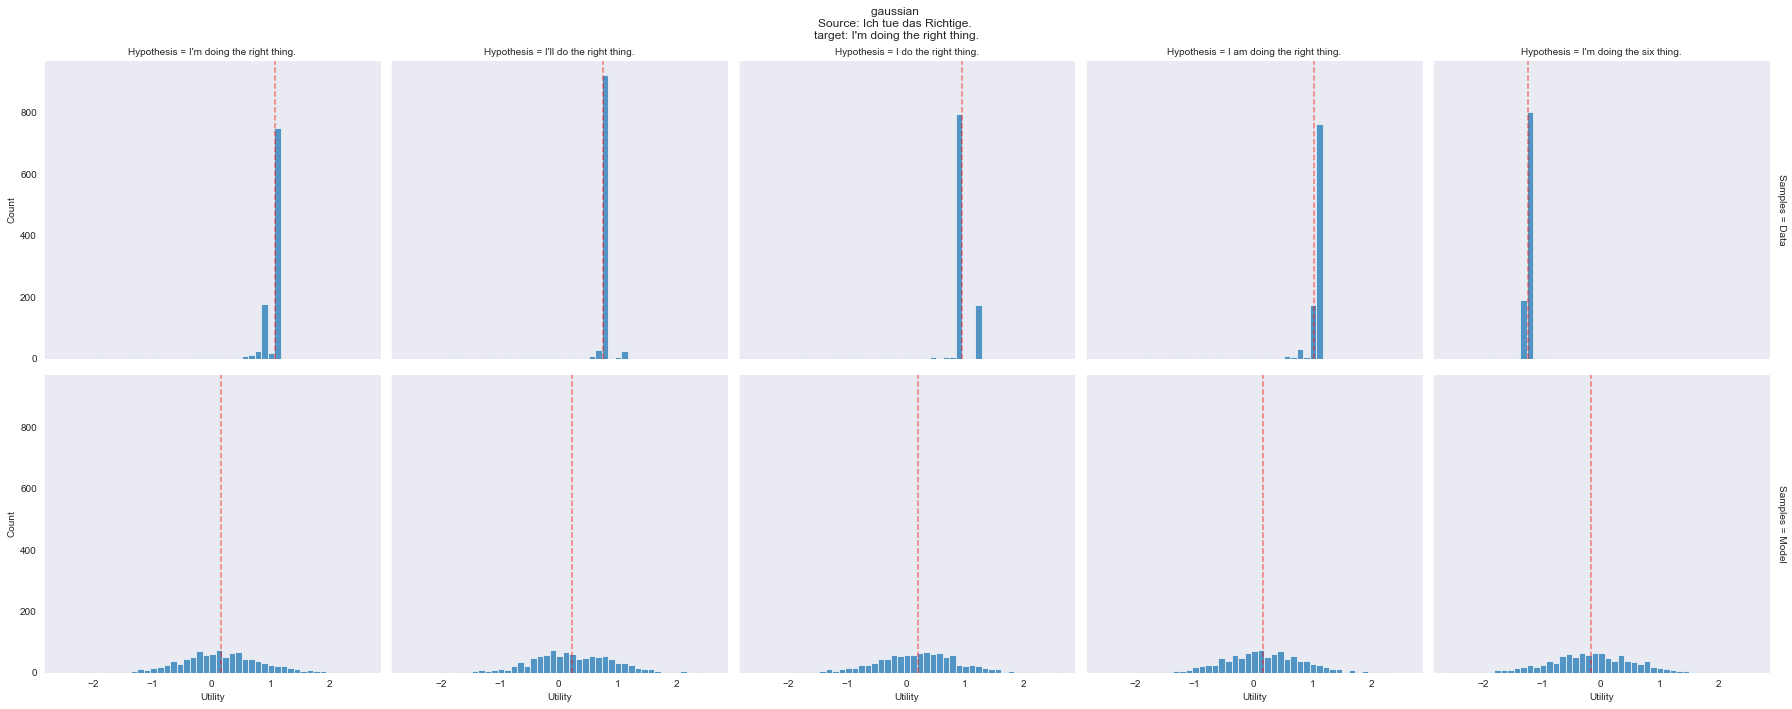

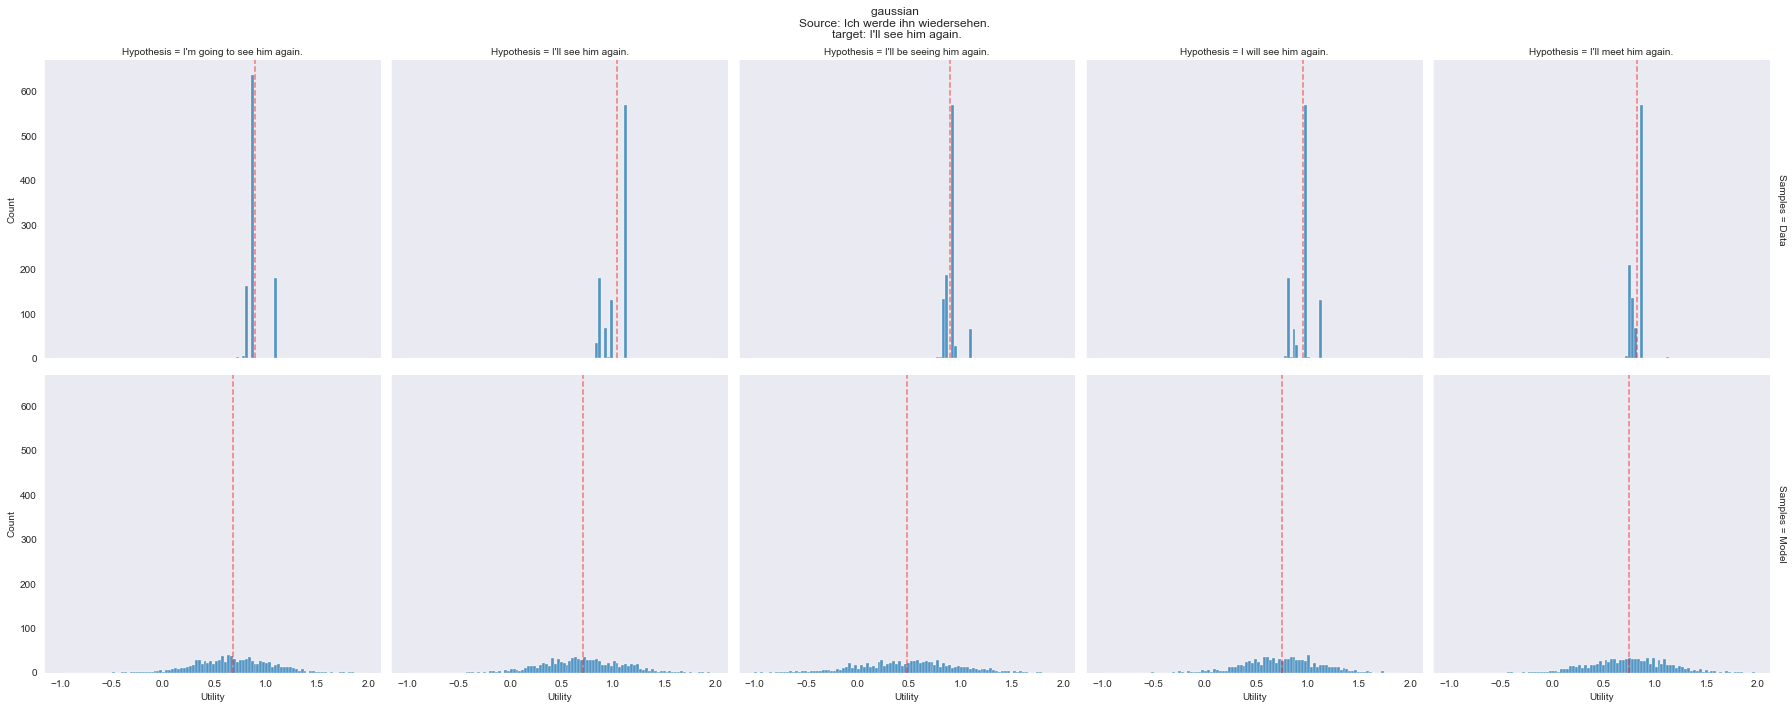

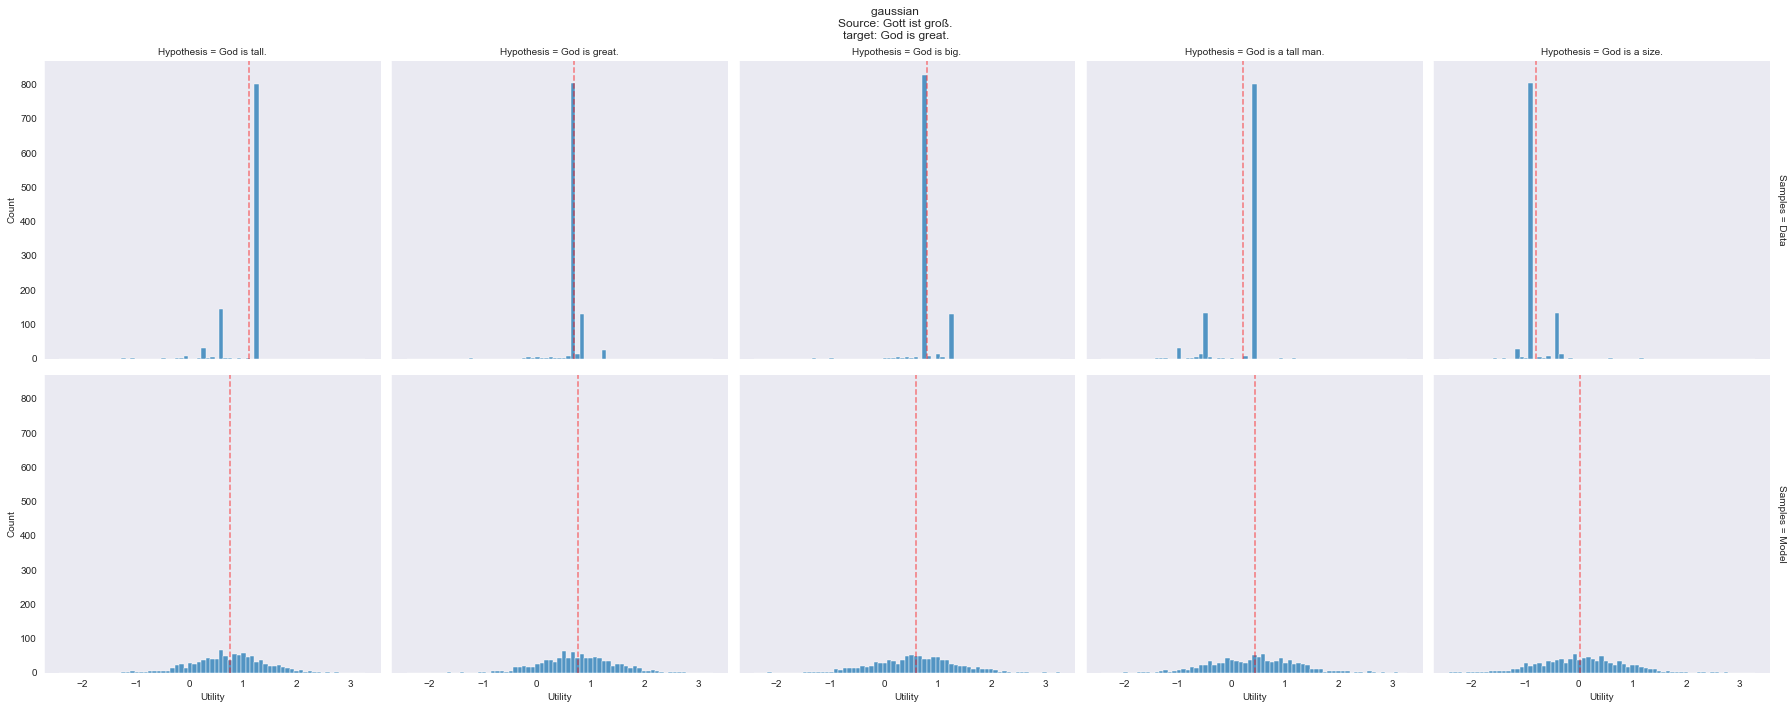

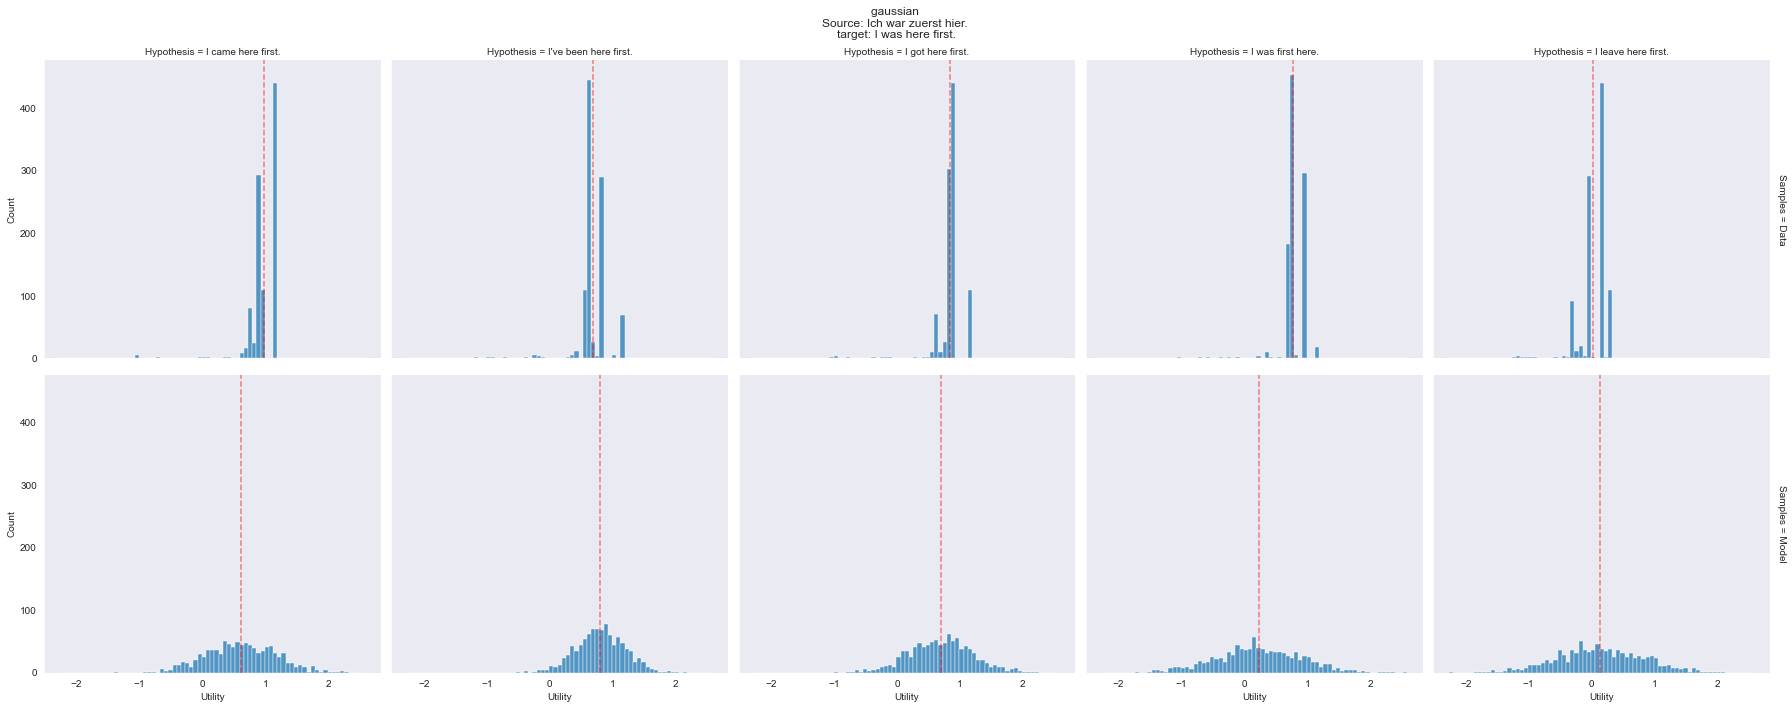

C:\Users\gerso\anaconda3\envs\thesis\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


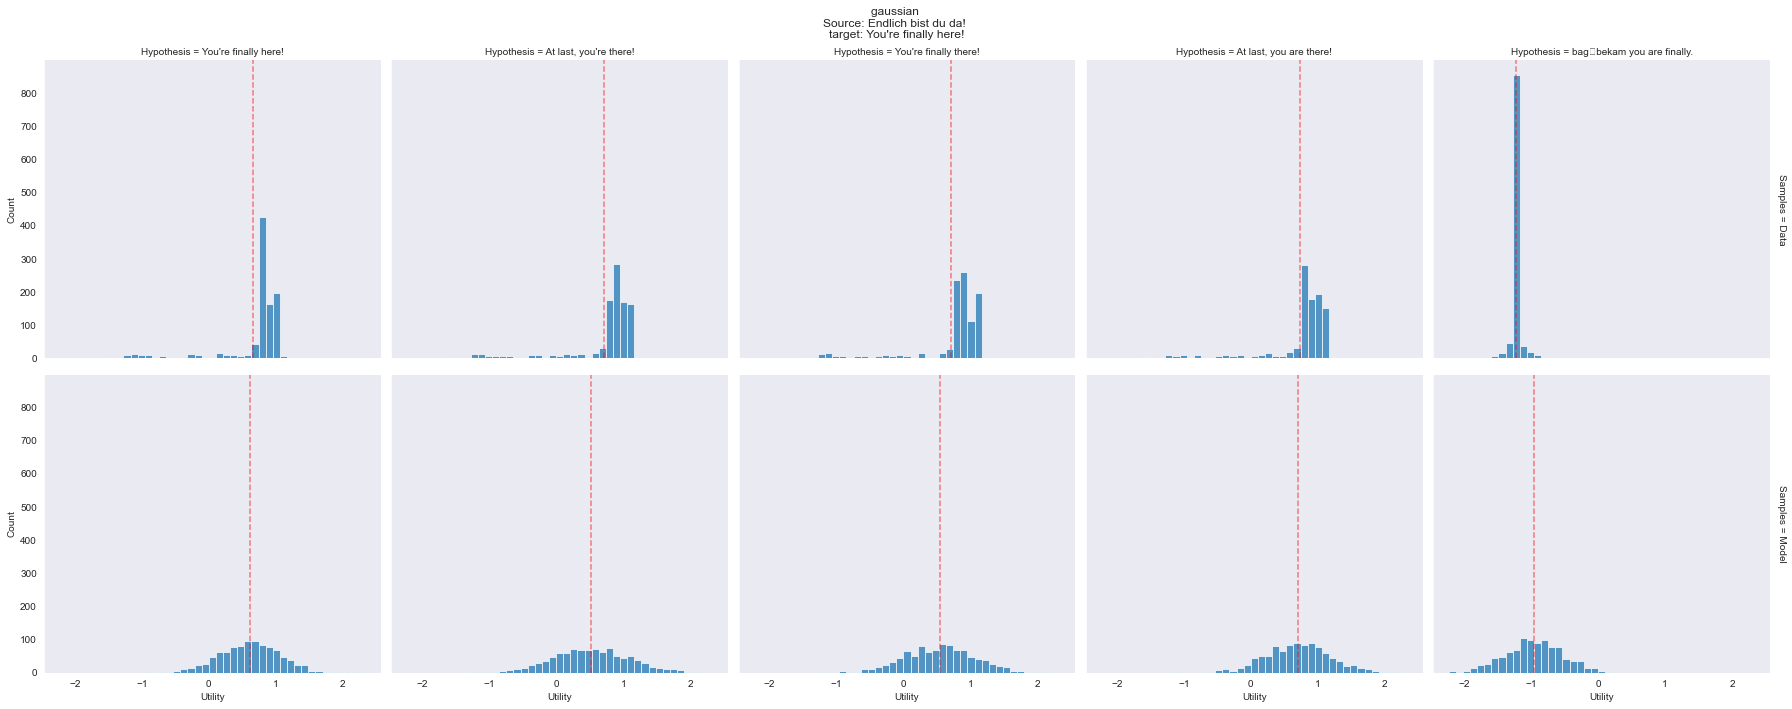

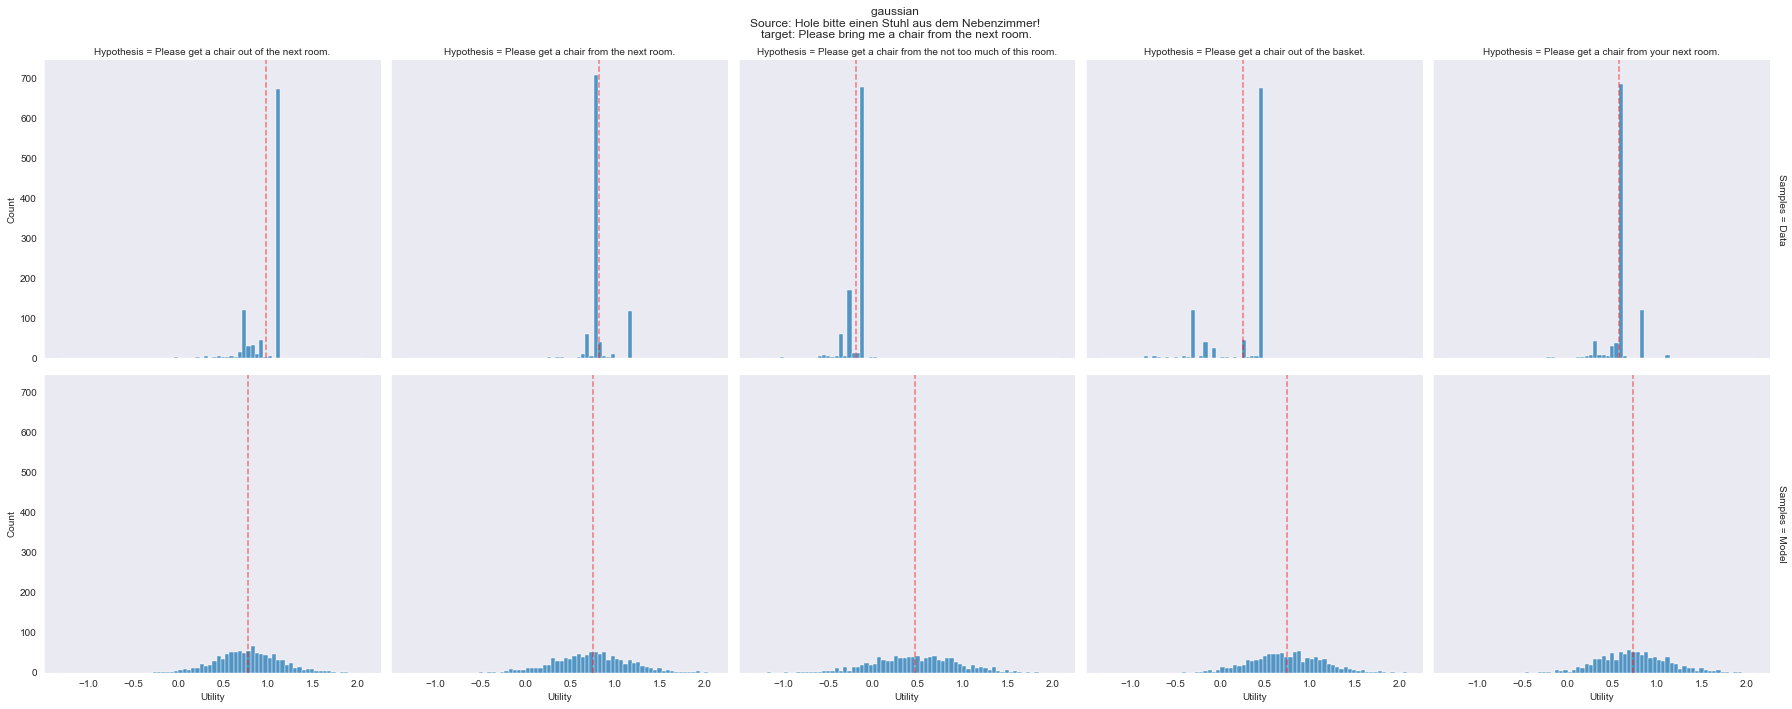

In [11]:
from pathlib import Path

# We want to create some plots for random samples
def compare_random_samples(data, model, model_name, n_examples=10, seed=1, max_show=5, save=True, path='./'):
    np.random.seed(seed)
    indices = np.random.choice(len(data), size=n_examples)
    
    for i in indices:
        entry = data.iloc[i]
        source = entry["source"]
        hypotheses = np.array(entry["hypotheses"])
        
        source = entry["source"]
        target = entry["target"]
        hypotheses = entry["hypotheses"].tolist()
        utilities = get_repeated_utils(entry["utilities"], entry["utilities_count"])
        plot_distributions(source, target, hypotheses, utilities, wrapped_model, model_name, path=path)
        
img_path_str =  path + 'validation_imgs/'
img_path = Path(img_path_str)
img_path.mkdir(parents=True, exist_ok=True)
compare_random_samples(validation_dataset.data, wrapped_model, model_name, path=img_path)
        
    
    
    





In [12]:

### Do the same for the training data:
train_dataset_loader = BayesRiskDatasetLoader("train_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset_train = train_dataset_loader.load(type="pandas")

KeyboardInterrupt: 

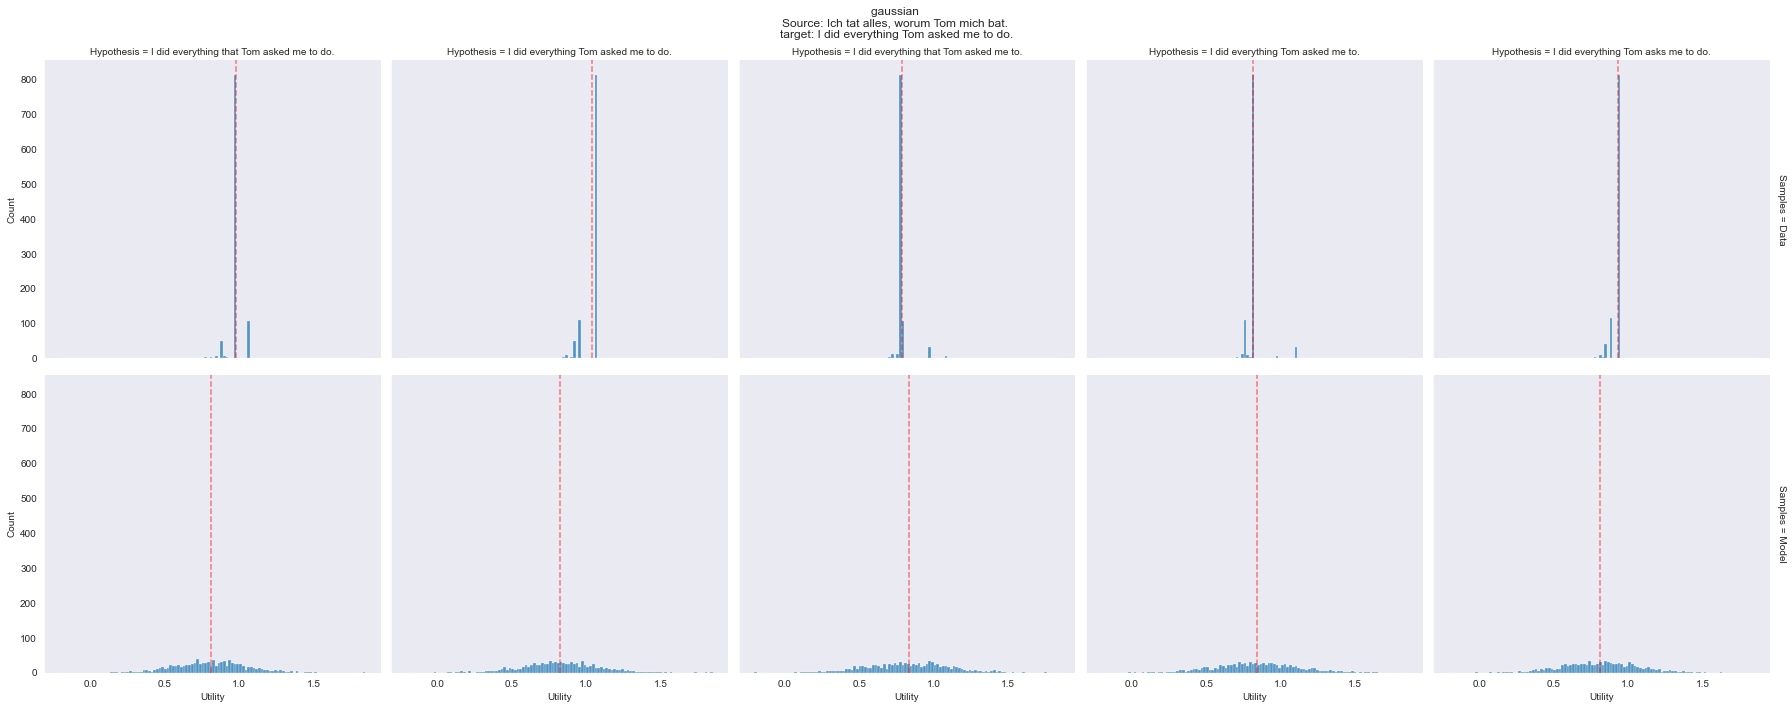

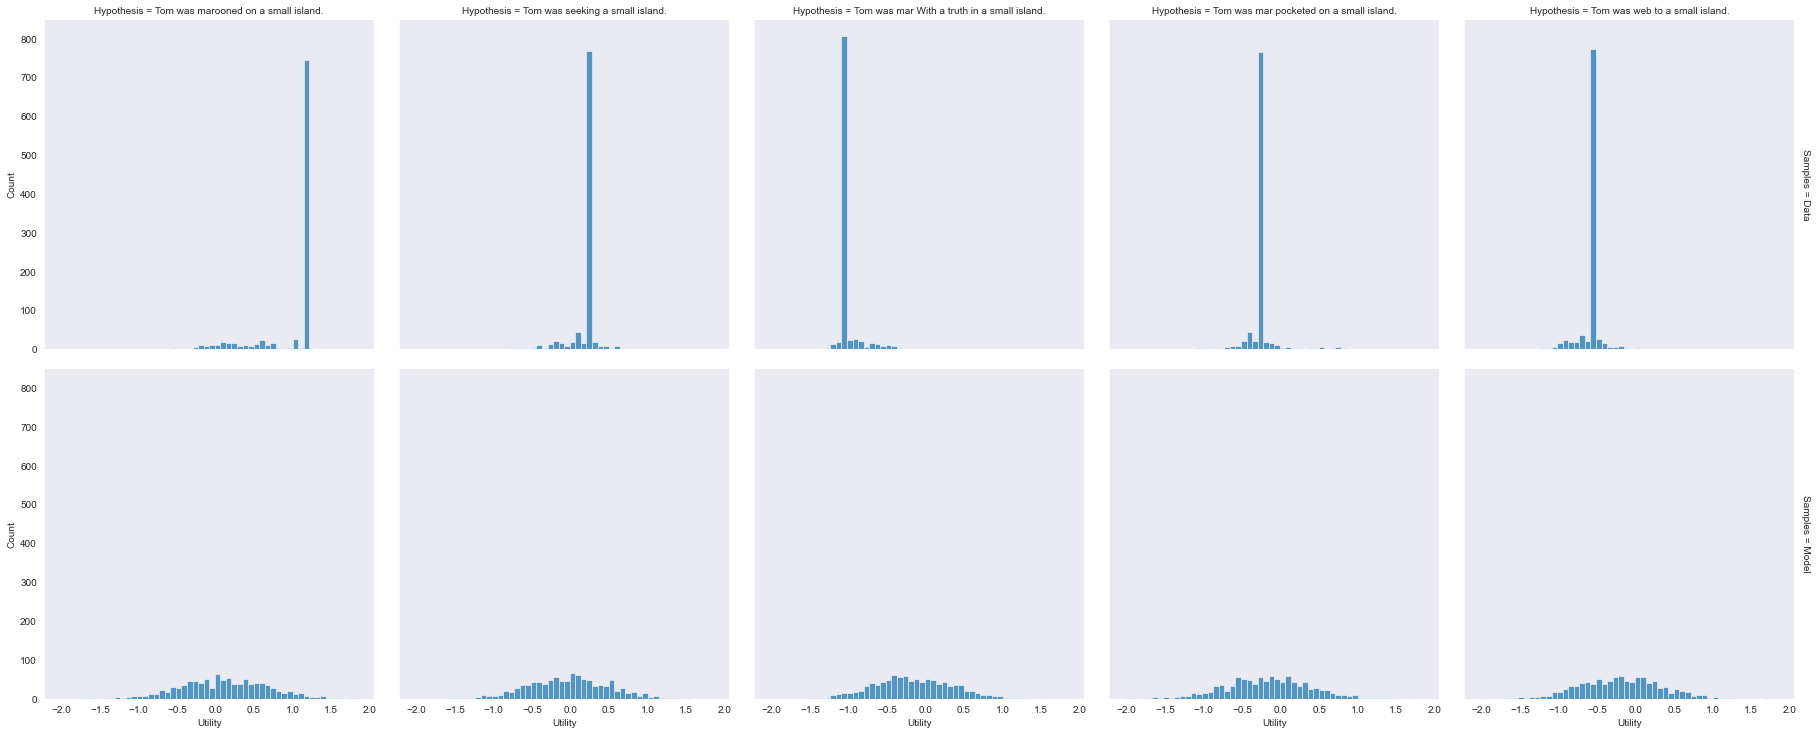

In [13]:
        
img_path_str =  path + 'training_imgs/'
img_path = Path(img_path_str)
img_path.mkdir(parents=True, exist_ok=True)
compare_random_samples(dataset_train.data, wrapped_model, model_name, path=img_path)
        
    


In [32]:
### Next up we want to compute the MSE

# First we get the data mean of each hypothesis


# Then we get the predicted mean

all_mbr_scores = []
all_predicted_scores = []

for row in tqdm(validation_dataset.data.iterrows(), total=2500):
    i = row[0]
    entry = row[1]
        
    mbr_scores = calculate_mbr_scores(entry)

    s = all_samples[i]
    
    predicted_scores = np.mean(s, axis=1)
    all_mbr_scores.append(mbr_scores)
    all_predicted_scores.append(predicted_scores)







100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 430.51it/s]


In [33]:
# Next we are going to calculate the mean squared error
differences = []
c = 0
all_predicted_scores_flattened = []
all_mbr_scores_flattened = []
for target, predicted in zip(all_mbr_scores, all_predicted_scores):
    c += 1
    
    t = np.array(target)
    p = np.array(predicted).flatten()
    all_predicted_scores_flattened += p.tolist()
    all_mbr_scores_flattened += t.tolist()

    differences.append((t - p).tolist())
    
    



In [34]:


squared_errors = []



for diff_list in differences:    
    squared_errors.append(np.array(diff_list)**2)
    

    


flattened_squared_errors = []
for e in squared_errors:
    flattened_squared_errors += list(e)


flattened_squared_errors = []
for e in squared_errors:
    flattened_squared_errors += list(e)

print(np.mean(flattened_squared_errors))

print(np.max(flattened_squared_errors))

0.17615150550081224
4.341675308685189


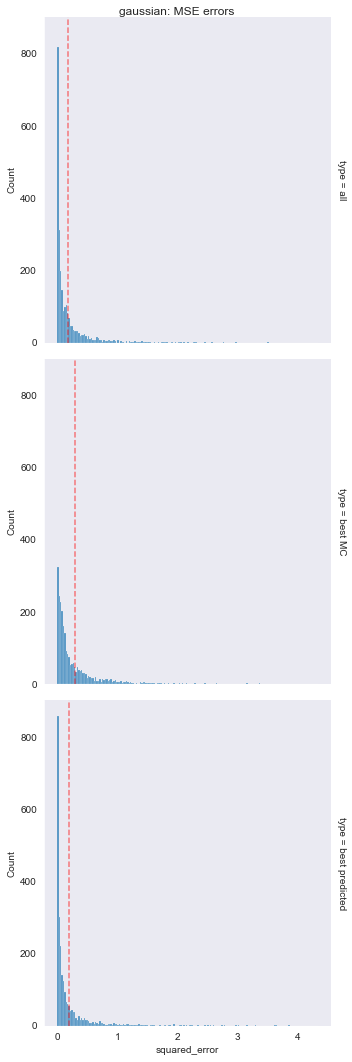

In [35]:
def compare_mse(squared_errors, mbr_scores, predicted_scores, path, model_name, seed=1, remove_high_values=True):
    np.random.seed(seed)
    target_best_errors = []
    predicted_best_errors = []
    flattened_squared_errors = []
    for e in squared_errors:
        flattened_squared_errors += list(e)
    # Next we get the error of the top pick compared to predicted one
    for target, predicted, errors in zip(all_mbr_scores, all_predicted_scores, squared_errors):
        best_target_index = np.argmax(target)
        best_predicted_index = np.argmax(predicted)
        target_best_errors.append(errors[best_target_index])
        predicted_best_errors.append(errors[best_predicted_index])
    
    data = {
        "squared_error": [],
        "type": [], #either all, best_target, best_predicted
    }

    flattened_squared_errors = np.random.choice(flattened_squared_errors, 2500).tolist()


    
    data["squared_error"] += flattened_squared_errors
    data["type"] += ["all"] *len(flattened_squared_errors)
     
    
   
    data["squared_error"] += target_best_errors
    data["type"] += ["best MC"] *len(target_best_errors)
    
 
    data["squared_error"] += predicted_best_errors
    data["type"] += ["best predicted"] *len(predicted_best_errors)
   
    
    df = pd.DataFrame.from_dict(data)

    g = sns.displot(df, x='squared_error', row='type', facet_kws=dict(margin_titles=True), )
    title = '{}: MSE errors'.format(model_name)

    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(title)

    def specs(x, **kwargs):
        avg = x.mean()
        plt.axvline(avg, c="red", alpha=0.5, linestyle='--', label="mean: {}".format(round(avg, 2)))

     
    g.map(specs, 'squared_error')
    
    fig = g.fig
    name = "squared_errors.png"
    save_file = str(path) + name 
    fig.savefig(save_file) 
    
    
compare_mse(squared_errors, all_mbr_scores, all_predicted_scores, path, model_name)

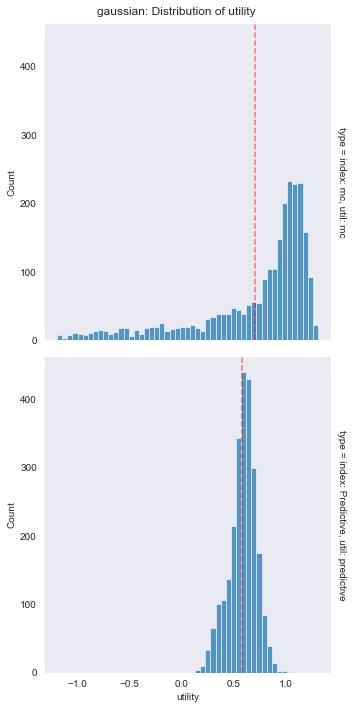

In [18]:
### We also plot the distribution of the best predictions found.

def compare_best_utilities(mbr_scores, predicted_scores, path, model_name):
    
    target_best = []
    predicted_best = []
    
    best_target_index_predicted_util = []
    
    best_predicted_index_mc_util = []
    
  
    for target, predicted, in zip(mbr_scores, predicted_scores):
        best_target_index = np.argmax(target)
        best_predicted_index = np.argmax(predicted)
        target_best.append(target[best_target_index].item())
        predicted_best.append(predicted[best_predicted_index].item())
        best_target_index_predicted_util.append(predicted[best_target_index].item())
        best_predicted_index_mc_util.append(target[best_predicted_index].item())
    
    data = {
        "utility": [],
        "type": [], #either all, best_target, best_predicted
    }
    

    
  
    data["utility"] += target_best
    data["type"] += ["index: mc, util: mc"] *len(target_best)
    
    data["utility"] += predicted_best
    data["type"] += ["index: Predictive, util: predictive"] *len(predicted_best)
    
#     data["utility"] += best_target_index_predicted_util
#     data["type"] += ["index: MC, util: prediction"] *len(predicted_best)
    
#     data["utility"] += best_predicted_index_mc_util
#     data["type"] += ["index: prediction, util: MC"] *len(predicted_best)
    
    
    df = pd.DataFrame.from_dict(data)
    
    g = sns.displot(df, x='utility', row='type', facet_kws=dict(margin_titles=True), )
    title = '{}: Distribution of utility'.format(model_name)
    
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(title)

    def specs(x, **kwargs):
        plt.axvline(x.mean(), c="red", alpha=0.5, linestyle='--')
        
    g.map(specs, 'utility')
        
    fig = g.fig
    name = "utility_dist.png"
    save_file = str(path) + name 
    fig.savefig(save_file) 
    
compare_best_utilities(all_mbr_scores, all_predicted_scores, path, model_name)